In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        _,y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [8]:
def Train(model,X,y,optimizer,criterion,num_epochs=1000):
# Step 3: Training loop

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Clear the gradients
    
        # Forward pass
        hidden_output, logits = model(X)
        
        # Compute loss
        loss = criterion(logits, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (num_epochs/10) == 0:
            model.eval()
            _,output=model(X)
            y_pred=torch.argmax(torch.softmax(output, dim=1), dim=1)
            acc=accuracy_fn(y,y_pred)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, accuracy: {acc:.4f}')
    
    # Step 4: Visualize the decision boundaries
    # Create a meshgrid for plotting
def showgraphs(model,X,n_hidden,n_output):
    x_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    input_data = np.c_[X_mesh.ravel(), Y_mesh.ravel()]
    
    # Convert meshgrid to PyTorch tensor
    input_data_torch = torch.tensor(input_data, dtype=torch.float32)
    
    # Make predictions (raw logits) from the trained model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        hidden_output, final_output = model(input_data_torch)
    
    # Convert output to numpy for plotting
    hidden_output_np = hidden_output.numpy().reshape(X_mesh.shape[0], X_mesh.shape[1], n_hidden)  # 5 hidden nodes
    final_output_np = final_output.numpy().reshape(X_mesh.shape[0], X_mesh.shape[1], n_output)  # 2 output nodes (logits)
    
    # Step 5: Plot the results
    fig = plt.figure(figsize=(18, 12))
    
    # Plot for each hidden node (5 hidden nodes)
    for i in range(n_hidden):
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.plot_surface(X_mesh, Y_mesh, hidden_output_np[:, :, i], cmap='coolwarm', edgecolor='none')
        ax.set_title(f'Hidden Layer Node {i+1} Output (ReLU)')
        ax.set_xlabel('Input X1')
        ax.set_ylabel('Input X2')
        ax.set_zlabel('Hidden Node Output')
    
    # Plot the output layer (2 output nodes, raw logits) as 3D plots
    for i in range(n_output):
        ax = fig.add_subplot(3, 3, i + 6, projection='3d')  # Use indices 6 and 7 for output nodes
        ax.plot_surface(X_mesh, Y_mesh, final_output_np[:, :, i], cmap='coolwarm', edgecolor='none')
        ax.set_title(f'Output Layer Node {i+1} (Raw Logits)')
        ax.set_xlabel('Input X1')
        ax.set_ylabel('Input X2')
        ax.set_zlabel('Output Node Logits')
    
    plt.tight_layout()
    plt.show()
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [19]:

# X_torch = torch.tensor(X_train, dtype=torch.float32)
# Y_torch = torch.tensor(y_train, dtype=torch.long)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define the hidden layer with 5 nodes
        self.hidden = nn.Linear(2, 5)  # Two inputs, five hidden nodes
        self.relu = nn.ReLU()
        # Define the output layer with 2 nodes (no softmax, we use raw logits)
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        hidden_output = self.relu(self.hidden(x))
        final_output = self.output(hidden_output)  # Raw logits
        return hidden_output, final_output
model = SimpleNN()
criterion = nn.CrossEntropyLoss()  # For binary classification, we use cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)




## Classification

In [6]:
import pandas as pd
df_train=pd.read_csv('Train.csv')
X_train=df_train.drop(columns=['label'],axis=1).to_numpy()
y_train=df_train['label'].to_numpy()
X_train.shape,y_train.shape
df_test=pd.read_csv('Test.csv')
X_test=df_test.drop(columns=['label'],axis=1).to_numpy()
y_test=df_test['label'].to_numpy()
X_train=torch.from_numpy(X_train).type(torch.float).to(device)
y_train=torch.from_numpy(y_train).type(torch.long).to(device)
X_test=torch.from_numpy(X_test).type(torch.float).to(device)
y_test=torch.from_numpy(y_test).type(torch.long).to(device)

In [9]:
Train(model,X_train,y_train,optimizer,criterion,num_epochs=10000)

Epoch [1000/10000], Loss: 0.0636, accuracy: 99.0205
Epoch [2000/10000], Loss: 0.0430, accuracy: 99.1095
Epoch [3000/10000], Loss: 0.0359, accuracy: 99.1986
Epoch [4000/10000], Loss: 0.0325, accuracy: 99.2876
Epoch [5000/10000], Loss: 0.0292, accuracy: 99.2876
Epoch [6000/10000], Loss: 0.0276, accuracy: 99.2876
Epoch [7000/10000], Loss: 0.0271, accuracy: 99.2876
Epoch [8000/10000], Loss: 0.0262, accuracy: 99.2876
Epoch [9000/10000], Loss: 0.0256, accuracy: 99.2876
Epoch [10000/10000], Loss: 0.0253, accuracy: 99.2876


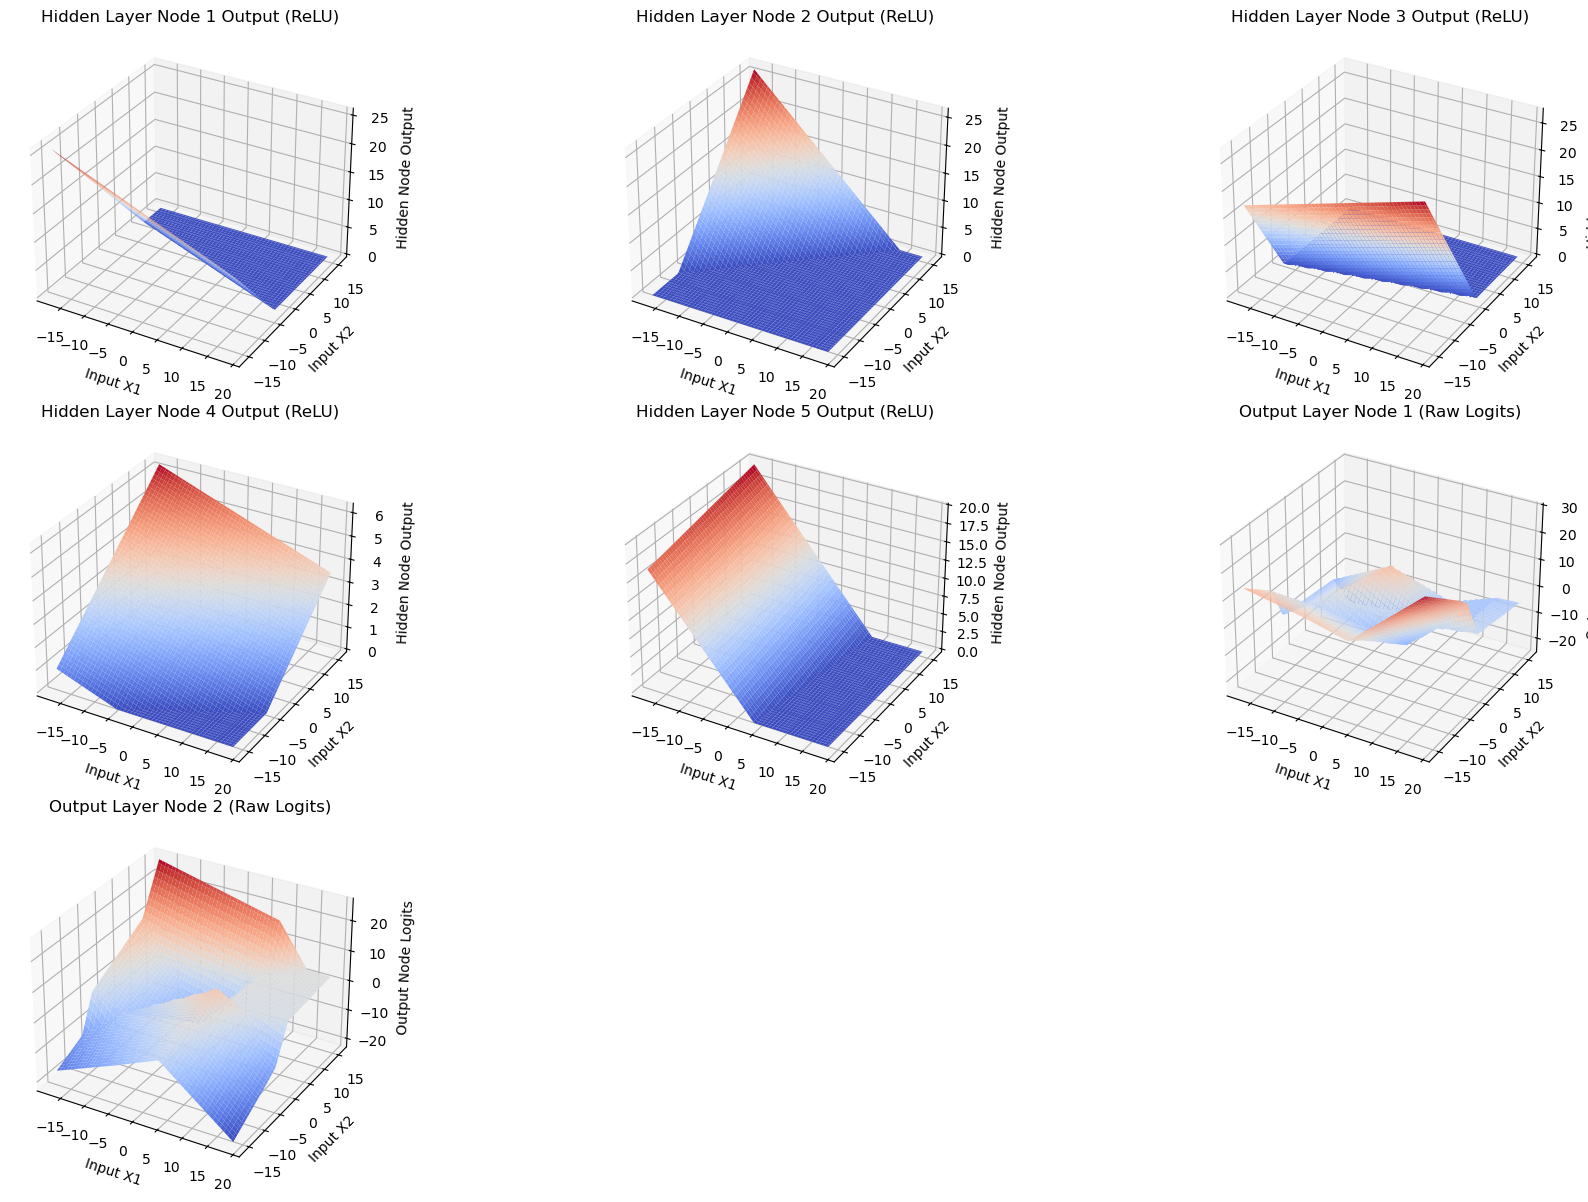

In [10]:
showgraphs(model,X_train,5,2)

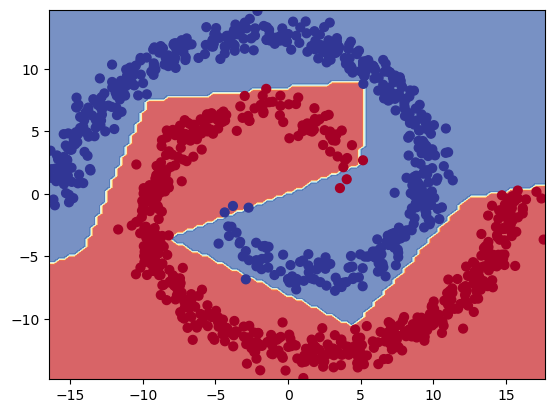

In [11]:
plot_decision_boundary(model, X_train, y_train)

## Function approximation

In [30]:
X=np.arange(0,2*np.pi,0.1).astype(np.float32).reshape(-1,1)
y=np.sin(X)

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [32]:
X_train = torch.from_numpy(X_train)  # Convert to torch tensor
Y_train = torch.from_numpy(y_train)

In [75]:

# Define the function approximator model for sin(x)
class SinApproximator(nn.Module):
    def __init__(self):
        super(SinApproximator, self).__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=5)  # More hidden neurons for better approximation
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        self.tanh = nn.Tanh()  # Activation function

    def forward(self, x):
        # Forward pass through the network
        hidden_output = self.tanh(self.layer1(x))
        result = self.layer2(hidden_output)
        return hidden_output,result

# Instantiate the model
model = SinApproximator()

# Loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [56]:

# Training loop
epochs = 3000
losses = []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    
    # Forward pass: Compute predicted y by passing x to the model
    _,y_pred = model(X_train)
    
    # Compute and print loss
    loss = loss_fn(y_pred, Y_train)
    # losses.append(loss.item())
    
    # Zero gradients, backpropagation, and update model weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Evaluate and plot the results



Epoch 500/3000, Loss: 0.031351
Epoch 1000/3000, Loss: 0.030948
Epoch 1500/3000, Loss: 0.030600
Epoch 2000/3000, Loss: 0.030296
Epoch 2500/3000, Loss: 0.030025
Epoch 3000/3000, Loss: 0.029781


In [76]:
Train(model,X_train,Y_train,optimizer,loss_fn,num_epochs=1000)

Epoch [100/1000], Loss: 0.0970
Epoch [200/1000], Loss: 0.0588
Epoch [300/1000], Loss: 0.0465
Epoch [400/1000], Loss: 0.0419
Epoch [500/1000], Loss: 0.0391
Epoch [600/1000], Loss: 0.0372
Epoch [700/1000], Loss: 0.0357
Epoch [800/1000], Loss: 0.0345
Epoch [900/1000], Loss: 0.0336
Epoch [1000/1000], Loss: 0.0328


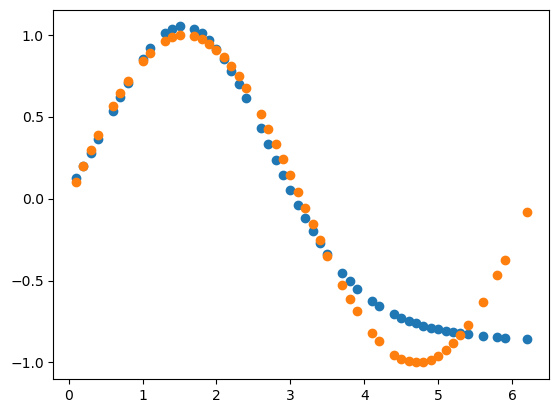

In [77]:
plt.scatter(X_train,res.detach().numpy())
plt.scatter(X_train,Y_train)

In [66]:
def Train(model,X,y,optimizer,loss_fn,num_epochs=1000):
# Step 3: Training loop

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
    
        # Forward pass
        hidden_output, logits = model(X)
        
        # Compute loss
        loss = loss_fn(logits, y)
        optimizer.zero_grad()  # Clear the gradients
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (num_epochs/10) == 0:
            model.eval()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

In [94]:
np.random.seed(42)
num_samples = 1000
x_train = np.random.uniform(-2 * np.pi, 2 * np.pi, num_samples).reshape(-1, 1)
y_train = np.random.uniform(-2 * np.pi, 2 * np.pi, num_samples).reshape(-1, 1)

# Define a function that takes x and y and computes z = sin(x) + cos(y)
z_train = np.sin(x_train) + np.cos(y_train)

# Stack x and y to create a two-column input for the neural network
xy_train = np.hstack([x_train, y_train])

# Convert data to torch tensors
X_train = torch.from_numpy(xy_train).float()  # Shape: [num_samples, 2]
Z_train = torch.from_numpy(z_train).float().view(-1, 1)  # Shape: [num_samples, 1]


In [95]:
class fnApprox(nn.Module):
    def __init__(self):
        super(fnApprox, self).__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)  # More hidden neurons for better approximation
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Forward pass through the network
        hidden_output = self.relu(self.layer1(x))
        result = self.layer2(hidden_output)
        return hidden_output,result


In [96]:
model = fnApprox()

# Loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [103]:
Train(model,X_train,Z_train,optimizer,loss_fn,num_epochs=10000)

Epoch [1000/10000], Loss: 1.4359
Epoch [2000/10000], Loss: 0.5795
Epoch [3000/10000], Loss: 0.5778
Epoch [4000/10000], Loss: 0.5698
Epoch [5000/10000], Loss: 0.5699
Epoch [6000/10000], Loss: 0.5845
Epoch [7000/10000], Loss: 0.5773
Epoch [8000/10000], Loss: 1.2041
Epoch [9000/10000], Loss: 0.5660
Epoch [10000/10000], Loss: 0.5981


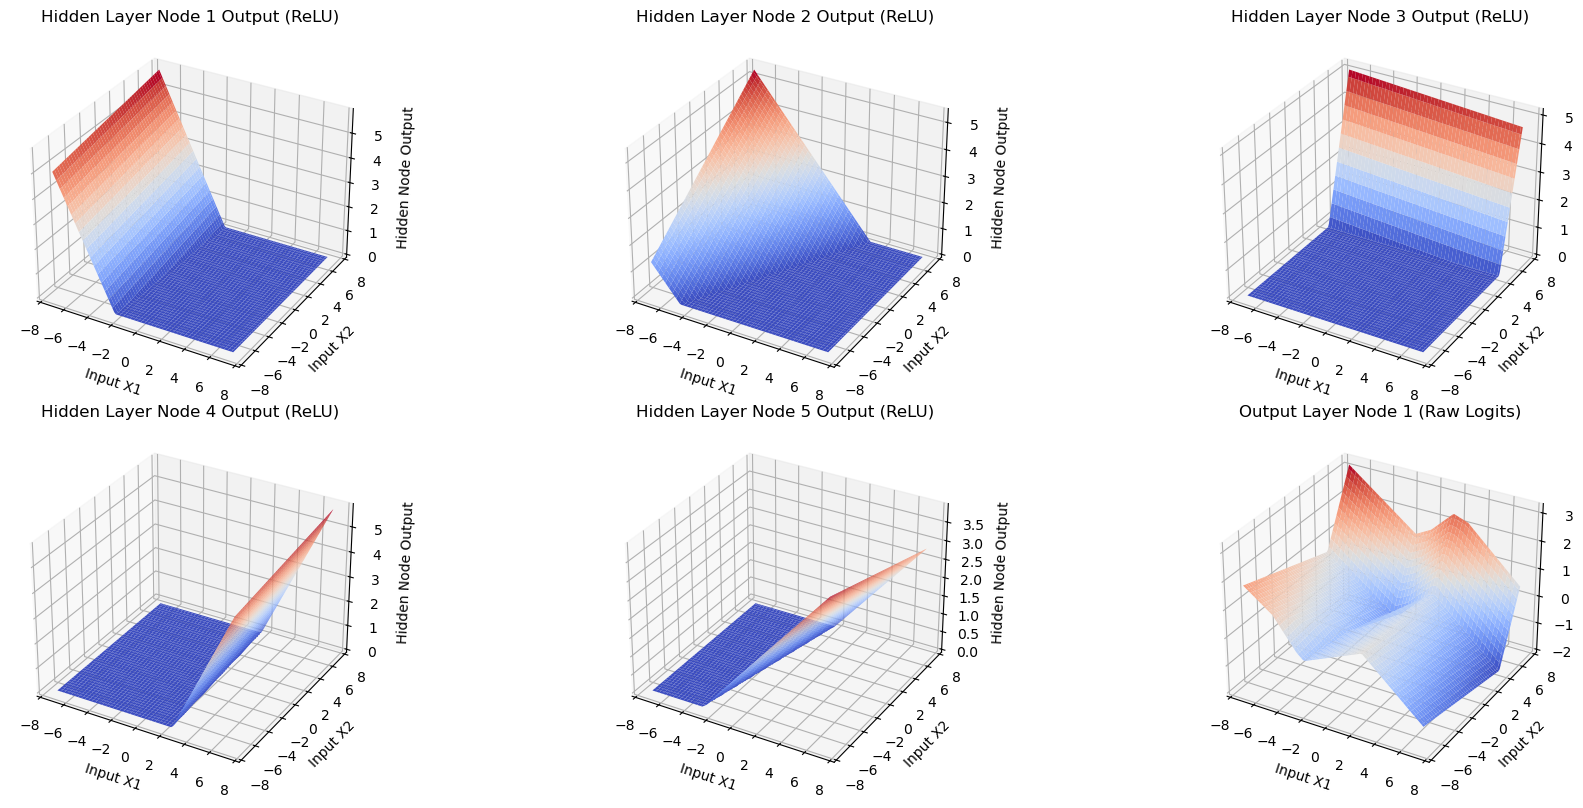

In [104]:
showgraphs(model,X_train,5,1)